# An experiment/simulation to understand Simpson Paradox

## Motivation

Thông qua một ví dụ về thử nghiệm ngẫu nhiên có kiểm soát (RCT hay A/B test) trong một chiến dịch Marketing, ta sẽ thấy được:

- Sự khác biệt giữa quan sát ngẫu nhiên trong quần thể (population) và khi có sự xuất hiện của 1 RCT;
- Hạn chế của thống kê quy ước trong cả hai trường hợp -> tầm quan trọng của suy luận nhân quả.



In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("Set1")

np.random.seed(42)

## Scenario 1: Random observed data
*Dữ liệu quan sát ngẫu nhiên*

Marketer có trong tay 1 `DataFrame` gồm 2 biến binary:

- `T`: 0 ~ không thực hiện chiến dịch quảng cáo mới, 1 ~ có thực hiện
- `Y`: 0 ~ không mua hàng trong session đầu ngay sau chiến dịch, 1 ~ có mua (hoặc có click vào sản phẩm ~ CTR).

In [26]:
def simulate_bin(
    sample_size: int = 1000,
    force_treatment: np.ndarray = None,
    obs_confounder: bool = False,
) -> pd.DataFrame:
    """
    Simulate a binary outcome Y from a binary treatment T and a binary confounder C.
    All are binaries

    Causal Diagram:
    Nodes: (C, T, Y)
    Edges: (C -> T, C -> Y, T-> Y)

    Args:
    sample_size: size of the sample;
    force_treatment: treatment or not;
    obs_confounder: to show/observe confounder or not;

    Return:
    A 2-columns pandas dataframe if obs_confounder = False,
    A 3-columns pandas dataframe if obs_confounder = True
    """
    p_c = 0.5  # confounder prob
    p_t_c = [0.8, 0.2]  # prob of treatment, with confounder c
    p_y_tc = [0.9, 0.7, 0.3, 0.1] # prob of outcome, with treatment t and confounder c

    # confounder
    c = np.random.binomial(n=1, p=p_c, size=sample_size)

    if force_treatment is not None:
        assert len(force_treatment) == sample_size
        t = force_treatment
    else:
        p_t = np.choose(c, p_t_c)
        # https://numpy.org/doc/2.1/reference/generated/numpy.choose.html
        # treatment
        t = np.random.binomial(n=1, p=p_t, size=sample_size)

    p_y = np.choose(c * 2 + t, p_y_tc)
    # outcome
    y = np.random.binomial(n=1, p=p_y, size=sample_size)

    if obs_confounder:
        return pd.DataFrame({"T": t, "Y": y, "C": c})

    return pd.DataFrame({"T": t, "Y": y})

Tạo mẫu dữ liệu với 1000 quan sát, không bắt buộc có treatment, không thể hiện confounder:

In [27]:
obs_data = simulate_bin(sample_size=1000, force_treatment=None, obs_confounder=False)
obs_data.head()

,T,Y
0,0,0
1,1,0
2,1,0
3,0,0
4,0,1


### Traditional statistics

Một pivot table đơn giản để xem qua số liệu:

In [28]:
xtab = pd.crosstab(obs_data["T"], obs_data["Y"])

xtab

Y,0,1
T,,
0,276,231
1,202,291


In [29]:
100 * xtab[1] / xtab.aggregate("sum", axis=1)

T
0    45.562130
1    59.026369
dtype: float64

In [31]:
59.026369 - 45.562130

13.464239

In [32]:
def estimate_effect(ds):
    base = ds[ds["T"] == 0]
    variant = ds[ds["T"] == 1]

    delta = variant.Y.mean() - base.Y.mean()

    delta_err = 1.96 * np.sqrt(
        variant.Y.var() / variant.shape[0] + base.Y.var() / base.shape[0]
    )

    return f"Avg effect: {100 * delta:.2f}% : {100 * (delta - delta_err):.2f}% to {100 * (delta + delta_err):.2f}%"


estimate_effect(obs_data)

'Avg effect: 13.46% : 7.32% to 19.61%'

Với khoảng tin cậy (CI) 95%, hiệu ứng trung bình là 13.46%. Xa hơn nữa, bạn Marketer thực hiện một kiểm định Chi square test, với ngưỡng ý nghĩa thống kê rất thấp là 0.001:

In [33]:
from scipy.stats import chi2_contingency


def chi_square(xtab, thres=0.0001):
    chi2_out = chi2_contingency(xtab)
    if chi2_out[1] < thres:
        print(
            f"Có liên hệ ý nghĩa giữa T và Y, Chi2 = {chi2_out[0]:02f}, p_value = {chi2_out[1]:02f}"
        )
    else:
        print(
            f"T và Y độc lập với nhau, Chi2 = {chi2_out[0]:02f}, p_value = {chi2_out[1]:02f}"
        )


chi_square(xtab, thres=0.0001)

Có liên hệ ý nghĩa giữa T và Y, Chi2 = 17.624572, p_value = 0.000027


Kết quả thật đẹp. Sếp gợi ý làm thêm mô hình Logistic để tính Odds_ratio. Ta sẽ làm như vậy:

In [34]:
import statsmodels.formula.api as sm

model_1 = sm.logit(data=obs_data, formula="Y ~ T").fit()

model_1.summary()

Optimization terminated successfully.
         Current function value: 0.683070
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 May 2025   Pseudo R-squ.:                 0.01316
Time:                        15:23:09   Log-Likelihood:                -683.07
converged:                       True   LL-Null:                       -692.18
Covariance Type:            nonrobust   LLR p-value:                 1.970e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1780      0.089     -1.996      0.046      -0.353      -0.003
T              0.5430      0.128      4.248      0.000       0.293       0.794
==============================================================================
"""

In [35]:
print(f"{np.exp(0.5430)}, {np.exp(0.293)}, {np.exp(0.794)}")

1.7211626125301187, 1.3404427904316814, 2.2122276626587873


Vậy áp dụng chiến dịch quảng cáo mới có thể làm tăng

## Scenario 2: RCT

In [ ]:
def simulate_AB_test(simulate_bin, sample_size=1000):
    treat_size = int(sample_size / 2)
    control_size = sample_size - treat_size

    forced_treatment = np.concatenate(
        [np.ones(treat_size), np.zeros(control_size)]
    ).astype("int")
    rct_data = simulate_bin(sample_size=sample_size, force_treatment=forced_treatment)

    return rct_data


rct_data = simulate_AB_test(simulate_bin, sample_size=1000)

rct_data.head()

,T,Y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,0


In [ ]:
xtab_rct = pd.crosstab(rct_data["T"], rct_data["Y"])

xtab_rct

Y,0,1
T,,
0,299,201
1,211,289


In [ ]:
estimate_effect(rct_data)

'Avg effect: 17.60% : 11.49% to 23.71%'

In [ ]:
chi_square(xtab_rct, thres=0.001)

Có liên hệ ý nghĩa giữa T và Y, Chi2 = 30.288115, p_value = 0.000000


In [ ]:
model_2 = sm.logit(data=rct_data, formula="Y ~ T").fit()

model_2.summary()

Optimization terminated successfully.
         Current function value: 0.677372
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 May 2025   Pseudo R-squ.:                 0.02248
Time:                        10:25:17   Log-Likelihood:                -677.37
converged:                       True   LL-Null:                       -692.95
Covariance Type:            nonrobust   LLR p-value:                 2.388e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3971      0.091     -4.354      0.000      -0.576      -0.218
T              0.7117      0.129      5.537      0.000       0.460       0.964
==============================================================================
"""

## Explanation

Tại sao kết quả đảo ngược hoàn toàn giữa (1) quan sát - hồi cứu, và (2) thử nghiệm ngẫu nhiên có đối chứng?

Thứ ta vừa chứng kiến là một trường hợp của nghịch lý Simpson. Trong cả 2 trường hợp, giá trị của `T` và `Y` được sinh ra từ một hệ thống có cấu trúc như nhau. xác suất `T = 1` phụ thuộc vào một biến `Z` và biến `Z` này cũng có liên hệ với `Y`.

Vậy `Z` là 1 confounder làm nhiễu kết quả của hiệu ứng can thiệt `Delta = Y|(T=1) - Y|(T=0)`. Trong ví dụ vừa rồi, `Z` bị ẩn đi tuy nhiên vẫn luôn chi phối `T` và `Y`, không phải lúc nào người ta cũng ý thức được điều này.

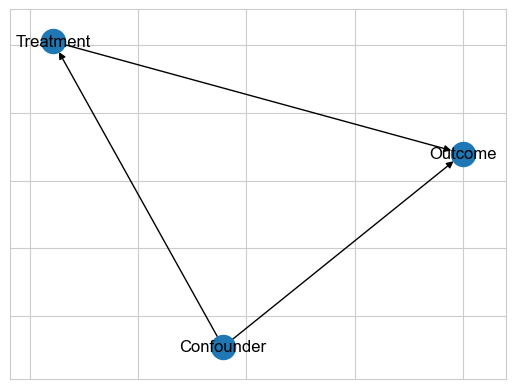

In [ ]:
import networkx as nx
from dowhy import gcm

# Create a causal graph using networkx and DoWhy's gcm module
model_obs = gcm.StructuralCausalModel(
    nx.DiGraph(
        [
            ("Confounder", "Treatment"),
            ("Confounder", "Outcome"),
            ("Treatment", "Outcome"),
        ]
    )
)

# Visualize the graph (requires matplotlib)
nx.draw_networkx(model_obs.graph, arrows=True, with_labels=True)
plt.show()


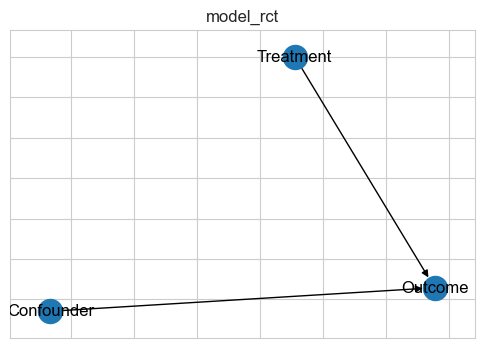

In [46]:
intervention_graph = model_obs.graph.copy()
incoming_edges = list(intervention_graph.in_edges('Treatment'))
intervention_graph.remove_edges_from(incoming_edges)
model_rct = gcm.StructuralCausalModel(intervention_graph)
plt.figure(figsize=(6,4))
nx.draw_networkx(model_rct.graph, arrows=True, with_labels=True)
plt.title('model_rct')
plt.show()

In [36]:
def simulate_AB_test_with_C(simulate_bin, sample_size=1000):
    treat_size = int(sample_size / 2)
    control_size = sample_size - treat_size

    forced_treatment = np.concatenate(
        [np.ones(treat_size), np.zeros(control_size)]
    ).astype("int")
    rct_data = simulate_bin(sample_size=sample_size
                            , force_treatment=forced_treatment
                            , obs_confounder=True)

    return rct_data


rct_with_c_data = simulate_AB_test_with_C(simulate_bin, sample_size=1000)

rct_with_c_data.head()

,T,Y,C
0,1,0,0
1,1,0,1
2,1,0,0
3,1,1,1
4,1,0,0


In [38]:
df_c0 = rct_with_c_data[rct_with_c_data.C == 0]
df_c1 = rct_with_c_data[rct_with_c_data.C == 1]

In [39]:
estimate_effect(df_c0)

'Avg effect: 19.55% : 12.66% to 26.45%'

In [40]:
estimate_effect(df_c1)

'Avg effect: 18.38% : 11.90% to 24.85%'

In [41]:
model_3 = sm.logit(data=rct_with_c_data, formula='Y ~ T + C').fit()

model_3.summary()

Optimization terminated successfully.
         Current function value: 0.457868
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.3390
Time:                        11:42:33   Log-Likelihood:                -457.87
converged:                       True   LL-Null:                       -692.70
Covariance Type:            nonrobust   LLR p-value:                1.035e-102
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1191      0.169    -12.539      0.000      -2.450      -1.788
T              1.3252      0.181      7.310      0.000       0.970       1.681
C              3.1613      0.182     17.387      0.000       2.805       3.518
==============================================================================
"""

## Backdoor adjustment with `DoWhy`

In [42]:
rct_with_c_data['T'] = rct_with_c_data['T'].astype('bool')

In [43]:
dg = 'digraph {T->Y; C-> Y; C->T}'

from dowhy import CausalModel

model = CausalModel(rct_with_c_data,
                    treatment = ['T'],
                    outcome = ['Y'],
                    graph = dg)

In [44]:
identified_estimand = model.identify_effect()

In [45]:
causal_esimate_strat = model.estimate_effect(identified_estimand,
                                             method_name = 'backdoor.propensity_score_stratification',
                                             target_units = 'att')

print(causal_esimate_strat)
print("Hiệu ứng can thiệp = " + str(causal_esimate_strat.value))


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|C])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,C,U) = P(Y|T,C)

## Realized estimand
b: Y~T+C
Target units: att

## Estimate
Mean value: 0.1897403158450535

Hiệu ứng can thiệp = 0.1897403158450535


## Conclusion

1. Dữ liệu bản thân nó không quan trọng bằng **quá trình/cơ chế** sinh dữ liệu;
2. Khi thực hiện RCT, cần chú ý tới **confounders**. Đồng thời RCT cũng sẽ ảnh hưởng trực tiếp đến tính ngẫu nhiên của dữ liệu (ta đã thay đổi quá khứ);
3. **Association/Correlation** khác/không tương đương với **Causal relationship**;
4. Simpson paradox là một trường hợp cực đoan khi RCT không kiểm soát tốt confounders, vi phạm giả định về **tính độc lập có điều kiện** của can thiệp (treatment);
5. Nếu quy trình phân tích không được dẫn đường bởi quy luật nhân quả, rất dễ rơi vào bẫy nghịch lý, dẫn đến **quyết định sai lầm**.

## References

- BS Le Ngoc Kha Nhi: <https://www.lengockhanhi.com/post/ngh%E1%BB%8Bch-l%C3%BD-simpson>